#Прогнозирование заказов такси

## Описание проекта
**Компания «Х» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нам необходимо создать модель для такого предсказания.**

**Значение метрики RMSE на тестовой выборке должно быть не больше 48.**


**В данных: количество заказов находится в столбце  'num_orders'**

---

In [61]:
# импорт библиотек
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression

from lightgbm import LGBMRegressor



---

## Анализ и предобработка данных

In [62]:
# монтирование Google Drive
from google.colab import drive
drive.mount('/content/drive')
!ls 'drive/My Drive/git_projects/0_predict_taxi_orders'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
taxi.csv  taxi_orders.ipynb


In [63]:
# загрузка данных
df = pd.read_csv('drive/My Drive/git_projects/0_predict_taxi_orders/taxi.csv',
                 index_col=[0], parse_dates=[0])

In [64]:
# первые 3 строки
df.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [66]:
# пропуски
df.isna().sum()

num_orders    0
dtype: int64

In [67]:
# аномалии меньше 0
df.query('num_orders < 0').count()

num_orders    0
dtype: int64

In [68]:
# 'num_orders' = 0
df.query('num_orders == 0').count()

num_orders    537
dtype: int64

In [69]:
# сортировка и ресемплирование по часу
df = df.sort_index()
df = df.resample('1H').sum()

In [70]:
# последовательность рядов.
df.index.is_monotonic

<ipython-input-70-752a0f4f02ee>:2: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  df.index.is_monotonic


True

In [71]:
# первые 3 строки
df.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


In [72]:
# срез 'num_orders' = 0
df.query('num_orders == 0')

,num_orders
datetime,
2018-04-06 06:00:00,0


In [73]:
print('Данные временного ряда с:', df.index.min(), 'по:', df.index.max())

Данные временного ряда с: 2018-03-01 00:00:00 по: 2018-08-31 23:00:00


In [74]:
# тренды и сезонность
decomposed = seasonal_decompose(df)

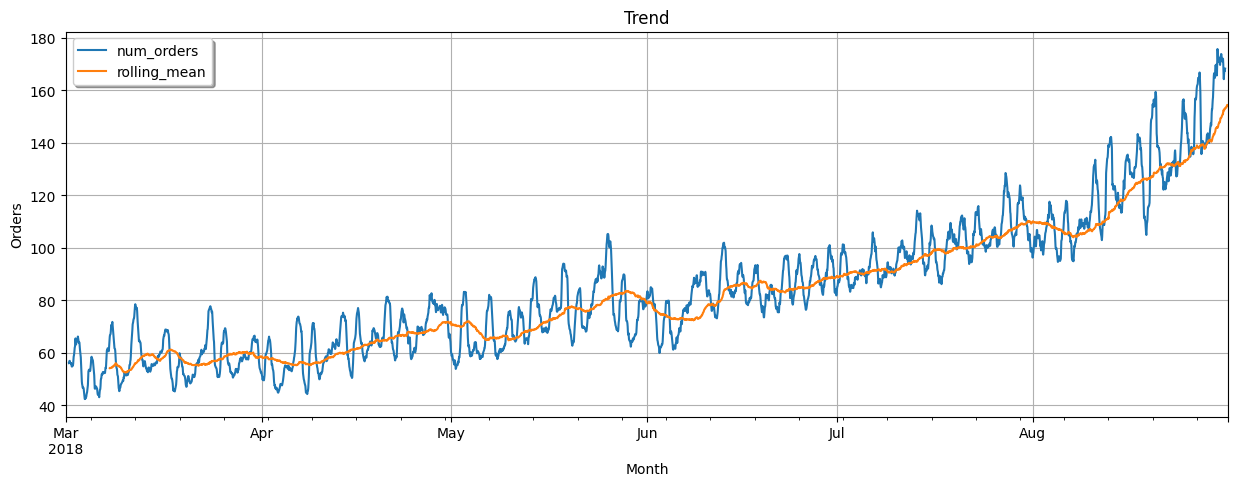

In [75]:
# тренд
plt.subplots(figsize=(15, 5))
decomposed.trend.plot(ax=plt.gca())
df.rolling(24*7).mean().plot(ax=plt.gca(), grid=True)
plt.legend(('num_orders', 'rolling_mean'), shadow=True)
plt.title('Trend')
plt.xlabel('Month')
plt.ylabel('Orders')
plt.show()

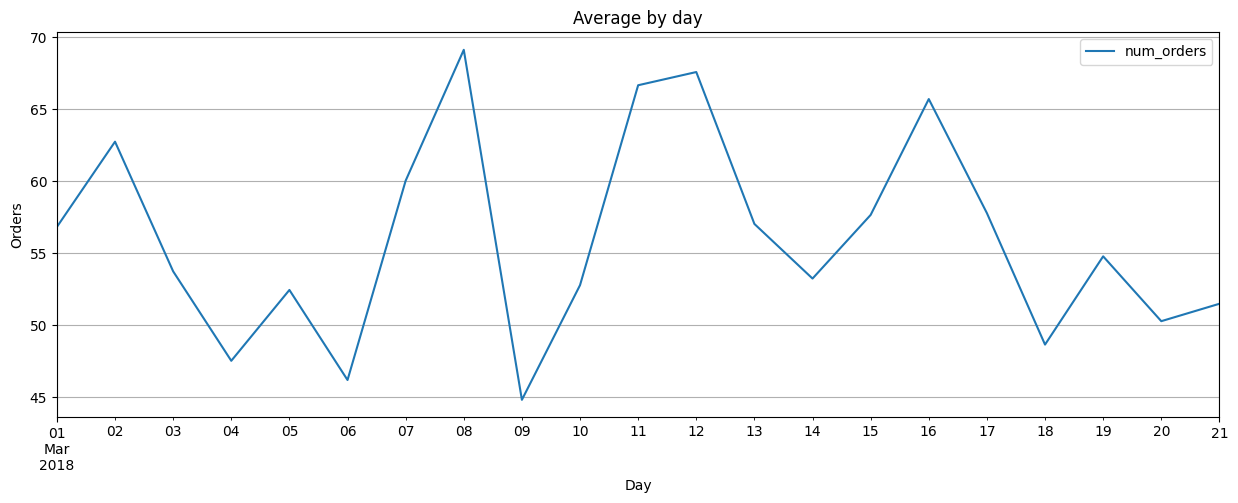

In [76]:
# среднее по дням в течении 3-х недель
plt.subplots(figsize=(15, 5))
df['2018-03-01':'2018-03-21'].resample('1D').mean().plot(ax=plt.gca(), grid=True)
plt.title('Average by day')
plt.xlabel('Day')
plt.ylabel('Orders')
plt.show()

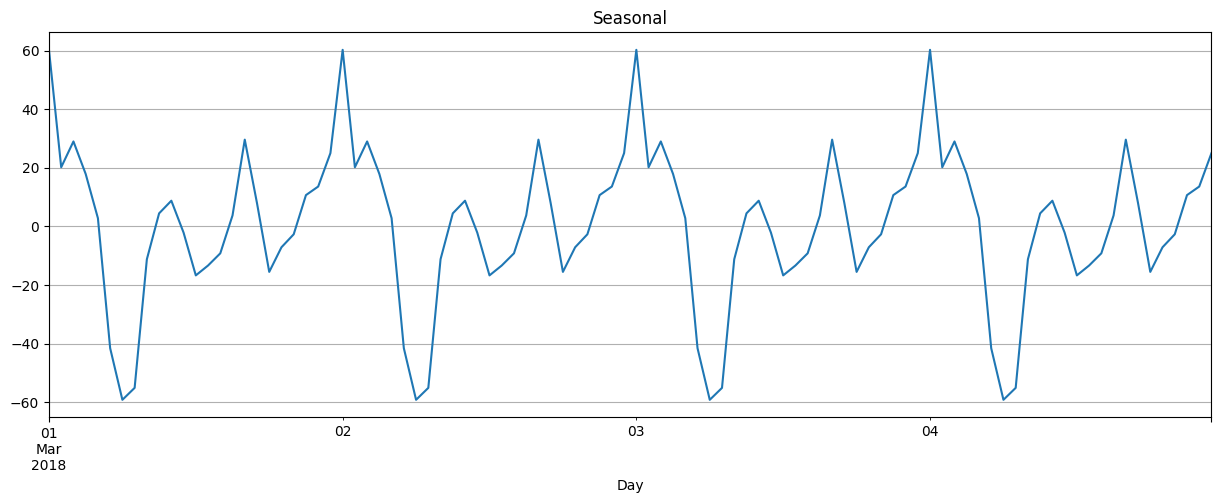

In [77]:
# сезонность
plt.subplots(figsize=(15, 5))
decomposed.seasonal['2018-03-01':'2018-03-04'].plot(ax=plt.gca(), grid=True)
plt.title('Seasonal')
plt.xlabel('Day')
plt.show()

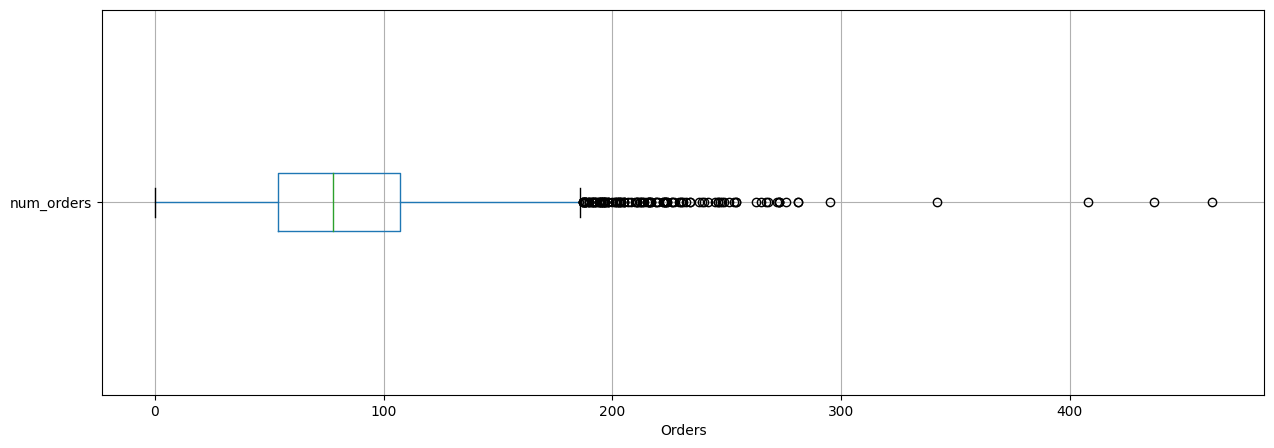

In [78]:
# аномалии
plt.subplots(figsize=(15, 5))
df.boxplot(vert=False)
plt.xlabel('Orders')
plt.show()

In [79]:
# срез 'num_orders' > 250
df.query('num_orders > 250')

,num_orders
datetime,
2018-04-24 00:00:00,253
2018-07-19 10:00:00,251
2018-08-13 01:00:00,273
2018-08-13 02:00:00,437
2018-08-18 00:00:00,281
2018-08-18 02:00:00,254
2018-08-20 01:00:00,272
2018-08-20 02:00:00,462
2018-08-20 04:00:00,273


### Заключение
В представленных данных:
- Временные ряды с 2018-03-01 00:00:00 по 2018-08-31 23:50:00 и значениями 'num_orders' - количество  заказов за интервал.
- Интервал 10 мин., ресемплировали данные с интервалом в 1 час.
- Пропусков нет.
- Встречаются нулевые значения, однако с интервалом в 10 мин это возможно. После ресемплирования с интервалом в 1 час нулевое значение встречается лишь один раз.
- Аномально высокие значения удалили (108 строк).
- Тренд по всем данным - количество заказов увеличивается, сложно судить с чем именно это связано, возможно  «Чётенькое такси» набирает популярность, возможно люди вообще стали чаще пользоваться такси или увеличивается пассажиропоток аэропорта.
- Зависимости от дней недели не обнаружено (например: выходной или нет).
- Сезонность выражается в течение дня с 6:00 до 24:00 количество заказов волнообразно растет с пиками около 10:00 и 16:00, далее с 24:00 до 6:00 количество снижается. Также сложно судить чем именно это обусловлено, возможно это связанно с загруженностью по количеству рейсов в час самого аэропорта.

---

## Подготовка данных

In [80]:
# создадим признаки
df['day_of_week'] = df.index.dayofweek
df['hour'] = df.index.hour

In [81]:
# медиана по дням недели
df.groupby('day_of_week')['num_orders'].median()

day_of_week
0    81.5
1    72.5
2    80.0
3    78.0
4    87.0
5    76.0
6    75.5
Name: num_orders, dtype: float64

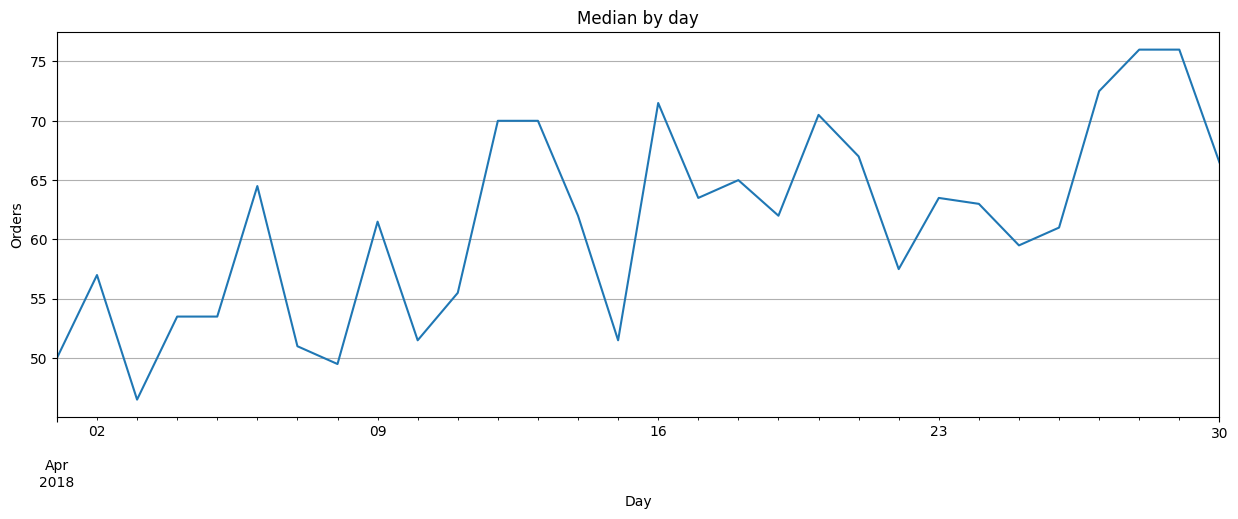

In [82]:
# медиана по дням
plt.subplots(figsize=(15, 5))
df['2018-04-01':'2018-04-30'].num_orders.resample('1D').median().plot(ax=plt.gca(), grid=True)
plt.title('Median by day')
plt.xlabel('Day')
plt.ylabel('Orders')
plt.show()

Для создания лагов и скользящего среднего создадим функцию, так будет удобнее поэкспериментировать с их количеством и размерами.


In [83]:
# функция для создаия лагов и скользящего среднего
def make_lags_rolmean(data, max_lag, rolling_mean_size):
    for lag in range(1, max_lag + 1):
        data['lag_'+str(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()

In [84]:
# создадим лаг, сдвиг на один час
# скользящее среднее за 24 часа
make_lags_rolmean(df, 1, 24)
df.head(9)

,num_orders,day_of_week,hour,lag_1,rolling_mean
datetime,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN
2018-03-01 02:00:00,71,3,2,85.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,NaN
2018-03-01 05:00:00,6,3,5,43.0,NaN
2018-03-01 06:00:00,12,3,6,6.0,NaN
2018-03-01 07:00:00,15,3,7,12.0,NaN
2018-03-01 08:00:00,34,3,8,15.0,NaN


In [85]:
# выборки
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop(columns='num_orders')
y_train = train['num_orders']
X_test = test.drop(columns='num_orders')
y_test = test['num_orders']

print('Размеры X_train:', X_train.shape[0], 'X_test:', X_test.shape[0])
print('X_train с:', X_train.index.min(), 'по:', X_train.index.max())
print('X_test с:', X_test.index.min(), 'по:', X_test.index.max())

Размеры X_train: 3950 X_test: 442
X_train с: 2018-03-02 00:00:00 по: 2018-08-13 13:00:00
X_test с: 2018-08-13 14:00:00 по: 2018-08-31 23:00:00


In [86]:
# первые 5 строк
X_train.head()

,day_of_week,hour,lag_1,rolling_mean
datetime,,,,
2018-03-02 00:00:00,4,0,58.0,56.833333
2018-03-02 01:00:00,4,1,90.0,55.416667
2018-03-02 02:00:00,4,2,120.0,56.875000
2018-03-02 03:00:00,4,3,75.0,57.041667
2018-03-02 04:00:00,4,4,64.0,56.958333


### Заключение

**Сделав предобработку, мы создали новые признаки: 'hour',	'lag_1', 'rolling_mean', 'day_of_week'. Разделили данные на выборки тестовую и тренировочную.**

---

## Модели

### LinearRegression

In [87]:
# RMSE
def rmse(target, predict):
    return mean_squared_error(target, predict)**0.5

In [88]:
# линейная регрессия.
lr = LinearRegression()

tscv = TimeSeriesSplit(n_splits=8)

scores  = cross_val_score(lr, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')

print('RMSE:', abs(scores))
print('Среднее RMSE:', abs(scores.mean()))

RMSE: [25.19863357 28.34649153 28.86438162 30.50888722 29.89605442 31.24927172
 35.74978955 41.12059899]
Среднее RMSE: 31.366763577025026


### LGBMRegressor

In [89]:
%%time
# создадим, обучим и подберем параметры для LGBMRegressor
lgb = LGBMRegressor(random_state=22)

parametrs = {
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': range(2, 11, 2),
    'num_leaves': [30, 40, 50]
    }

grid = GridSearchCV(
    lgb,
    param_grid=parametrs,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
    )

grid.fit(X_train, y_train)

print('Лучший результат:')
print('гиперпараметры: ', grid.best_params_)
print('RMSE: ', grid.best_score_)

Лучший результат:
гиперпараметры:  {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 50, 'num_leaves': 50}
RMSE:  -24.45643055648612
CPU times: user 3.91 s, sys: 308 ms, total: 4.22 s
Wall time: 1min 35s


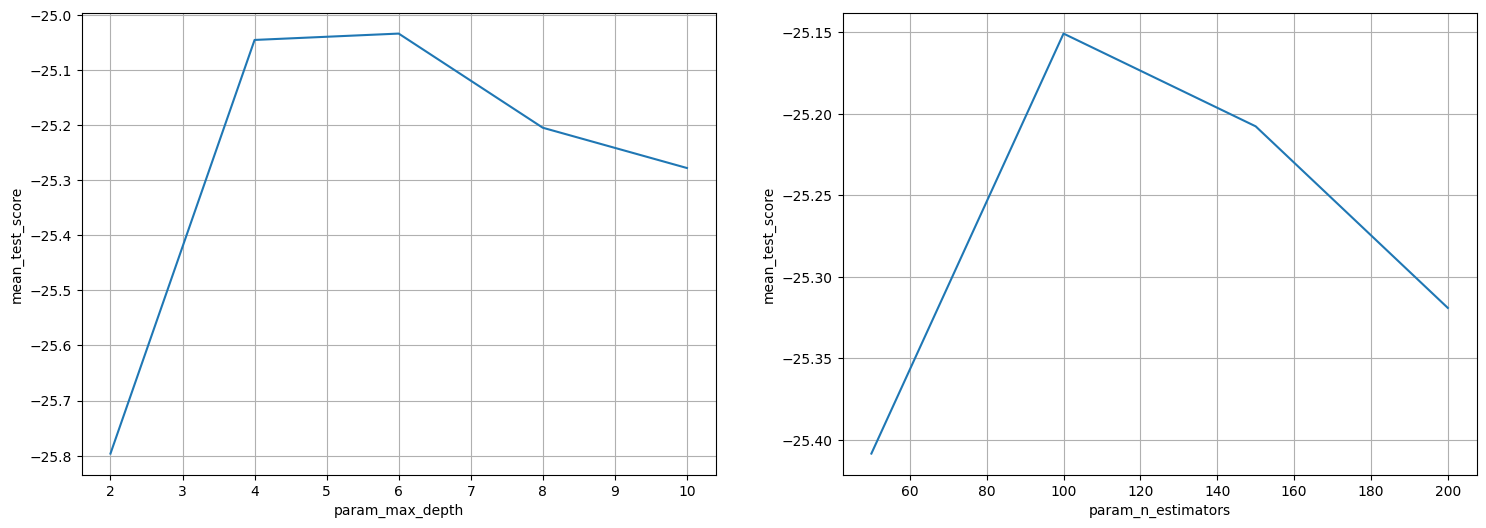

In [90]:
# построим графики.
# зависимость 'mean_test_score' от 'param_max_depth'.
# зависимость 'mean_test_score' от 'param_n_estimators'.

grid_res = pd.DataFrame(grid.cv_results_)

fig, ax = plt.subplots(1,2)
sns.lineplot(data=grid_res.groupby(
    'param_max_depth')['mean_test_score'].mean(), ax=ax[0])

sns.lineplot(data=grid_res.groupby(
    'param_n_estimators')['mean_test_score'].mean(), ax=ax[1])

ax[0].grid()
ax[1].grid()
fig.set_figheight(6)
fig.set_figwidth(18)
fig.show()

### Заключение
**Результаты моделей:**
- LinearRegression RMSE: 31.36
- LGBMRegressor RMSE: 24.45

**LGBMRegressor показала результаты лучше.**

## Тест модели

In [91]:
lgb = LGBMRegressor(learning_rate=.1, max_depth=4, n_estimators=100, num_leaves=50, random_state=22)
lgb.fit(X_train, y_train)
pred = lgb.predict(X_test)
print('RMSE:', rmse(y_test, pred))

RMSE: 43.953044765576166


In [92]:
# адекватность модели
# предскажем предыдущим значением
print('RMSE:', rmse(y_test, y_test.shift(periods=1, fill_value=y_train.iloc[-1])))

RMSE: 58.856486242815066


---

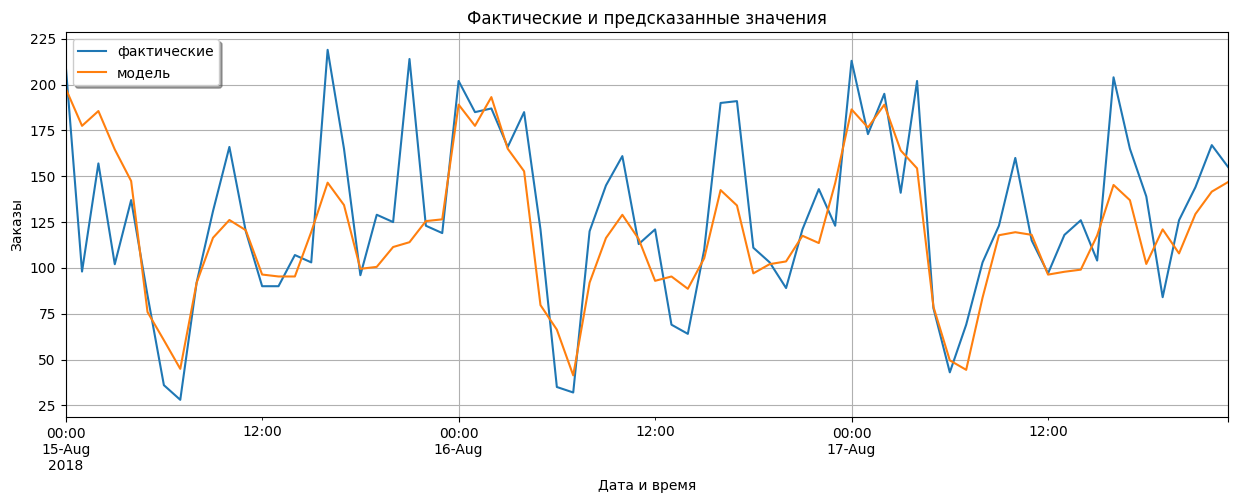

In [93]:
# спрогнозированные и фактические значения
plt.subplots(figsize=(15, 5))
y_test['2018-08-15':'2018-08-17'].plot(ax=plt.gca())
pd.DataFrame(pred, index=y_test.index)['2018-08-15':'2018-08-17'].plot(ax=plt.gca())
plt.grid(True)
plt.title('Фактические и предсказанные значения')
plt.legend(('фактические', 'модель'), shadow=True)
plt.ylabel('Заказы')
plt.xlabel('Дата и время')
plt.show()

## Итоги
**В ходе нашей работы мы проделали:**
1. Анализ и предобработку данных:
 - изучили данные
 - ресемплировали данные с интервалом в 1 час
 - определили тренд и сезонность
2. Подгототовку данных:
- сгенерировали признаки
- подготовили выборки
3. Подобрали модель LGBMRegressor, на тесте RMSE 43.95, что соответствует условию. Модель проверили на адекватность, предсказывая  предыдущим значением RMSE: 58.85, что значительно хуже.

4. На графике выше видно, что модель улавливает сезонность, но недостаточно отрабатывает пики, на тесте прогноз систематически ниже факта. Однако тест данные у нас в августе, а именно тут больше всего всплесков. Необходимо выяснить их природу (например акция, уход конкурента из-за которого начал меняться тренд). На трэйне мы обучались без него, следовательно, модель не научилась это учитывать.., мы бы добавили этот фактор в признаки (акция например) и модель бы лучше прогнозировала всплески!